## import packages and intake catalog

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
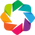

In [1]:
#import packages
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import colorcet as cc
import holoviews as hv
from colorcet.plotting import swatch, swatches, candy_buttons
hv.extension('bokeh')

In [2]:
#copy your local directory here
os.chdir('/Users/emmalayton/Desktop/senior_thesis/RFMIP-IRF_intake_catalogue/')

In [3]:
#open the catalog and experiment info
from intake import open_catalog
cat = open_catalog(os.getcwd() + '/main.yml')
extrainfo = xr.open_dataset(os.getcwd() + '/multiple_input4MIPs_radiation_RFMIP_UColorado-RFMIP-1-2_none.nc').to_dataframe()

## import data and compute global means

In [4]:
#scale RRTMG p1f1 data since it uses different boundary conditions than RFMIP protocol
#find the scaling factor at the boundary (top of atmosphere)
rrtmg_p1f1_scale = cat.benchmark.LBLRTM.p1f1.rsd.to_dask().rsd.isel(level=0)/cat.parameterized.RRTMG.p1f1.rsd.to_dask().rsd.isel(level=0)
#concatenate the RRTMG data
adjusted_rrtmg = xr.concat([cat.parameterized.RRTMG.p1f1[f].to_dask()
                for f in ["rsu","rsd", "rlu", "rld"]],
                dim="field", data_vars = "different")
adjusted_rrtmg['rsu'] = rrtmg_p1f1_scale*adjusted_rrtmg['rsu']
adjusted_rrtmg['rsd'] = rrtmg_p1f1_scale*adjusted_rrtmg['rsd']

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

In [5]:
#values at TOA (level=0) are the same
print((adjusted_rrtmg['rsd']-cat.benchmark.LBLRTM.p1f1.rsd.to_dask().rsd).isel(level=0).max())
#profile weights are the same
adjusted_rrtmg.profile_weight-cat.benchmark.LBLRTM.p1f1.rsd.to_dask().profile_weight
#computed global means are much higher for RRTMG than other parameterized models (see below)

<xarray.DataArray 'rsd' ()>
array(6.1035156e-05, dtype=float32)


<xarray.DataArray 'profile_weight' (site: 100)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
    lat      (site) float32 -28.5 28.5 31.5 87.0 36.0 ... 64.5 58.5 -3.0 -24.0
    lon      (site) float32 27.0 24.0 162.0 126.0 66.0 ... 3.0 184.5 250.5 246.0
    time     (site) datetime64[ns] 2014-01-05T06:00:00 ... 2014-12-30
Dimensions without coordinates: site

In [6]:
#method to compute weighted global mean
def compute_global_mean(ds):
    wts = ds.profile_weight/ds.profile_weight.sum()
    return(ds.weighted(wts).mean(["site"]))

In [7]:
#make this able to handle multiple datasets
def concatenate_dataset(ds, models, selected_experiments, variable, levels):
    #select data to plot
    pts = {m: ds[m][variable].sel(expt=selected_experiments, level=levels) for m in models if variable in ds[m]}
    pts_values = np.concatenate([ds[m][variable].sel(expt=selected_experiments, level=levels) 
                                                   for m in models if variable in ds[m]])
    return pts, pts_values


In [8]:
def set_plot_parameters(x, y, ds_name, selected_experiments, variable, levels, axis_titles, legend=True, logscale=False, bestfit=False, isoline=False, squareplot=False, x_values=None, y_values=None):
    
    #title
    benchmark, forcing_error, wavelength = "","","";
    if '_b' in ds_name:
        benchmark = "benchmark"
    if 'forcing' in ds_name:
        forcing_error = 'forcing'
    elif 'error' in ds_name:
        forcing_error = 'error'
    if 's' in variable:
        wavelength = 'SW'
    elif 'l' in variable:
        wavelength = 'LW'
    title=benchmark+" "+wavelength+" "+forcing_error+" in "+str(selected_experiments)+" at "+str(levels)
    plt.title(title)
    
    if logscale is True:
        plt.xscale('log')
        ax.set_xticks(x)
        ax.set_xticklabels(x)

    if bestfit is True:
        for m in list(y.keys()):
            if logscale is True:
                p = np.polyfit(np.log10(x), y[m], 1)    
                y_fitted = p[0] * np.log10(np.arange(min(x),max(x),0.1)) + p[1]
                plt.plot(np.arange(min(x),max(x),0.1),y_fitted)
            else:
                p = np.polyfit(x, y[m], 1)    
                y_fitted = p[0] * np.arange(min(x),max(x),0.1) + p[1]
                plt.plot(np.arange(min(x),max(x),0.1),y_fitted)
            
    #square plot    
    if squareplot is True:
        #plotting parameters
        maxval=max(np.concatenate((x_values, y_values)))
        minval=min(np.concatenate((x_values, y_values)))
        plt.xlim(1.2*minval,1.2*maxval)
        plt.ylim(1.2*minval,1.2*maxval)
    
    if isoline is True:
        isoline = np.linspace(1.2*minval,1.2*maxval, 1000)
        plt.plot(isoline, isoline, 'k', linestyle='solid', linewidth=0.65)

    
    #tick marks axes    
    plt.xlabel(axis_titles[0])
    plt.ylabel(axis_titles[1])
    
    #axes at x=0, y=0
    ax.axvline(x=0, color='k')
    ax.axhline(y=0, color='k')
    
    #legend
    plt.legend(list(y.keys()), frameon=False)
    
    return None

In [10]:
#store globally averaged benchmark/line-by-line model data in a dataframe, divided by shortwave/longwave and up/down
gbms_b = {}
for m in list(cat.benchmark):
    for r in list(cat.benchmark[m]):
        components = list(cat.benchmark[m][r])
        gbms_b[f'{m}_{r}'] = xr.concat([compute_global_mean(cat.benchmark[m][r][f].to_dask()) 
                                        for f in components], 
                                        dim="field", data_vars = "different")
        if "rsd" in components:
            gbms_b[f'{m}_{r}'] = gbms_b[f'{m}_{r}'].assign(rsn=gbms_b[f'{m}_{r}'].data_vars['rsd']-gbms_b[f'{m}_{r}'].data_vars['rsu'])

gbms_b = {k: gbms_b[k].assign(rln=gbms_b[k].data_vars['rld']-gbms_b[k].data_vars['rlu']) for k in gbms_b.keys()}
gbms_b = {k: gbms_b[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in gbms_b.keys()}

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

In [11]:
#store globally averaged parameterized model data in dataframe, divided by shortwave/longwave 
gbms = {}
for m in list(cat.parameterized):
    for r in list(cat.parameterized[m]):
        gbms[f'{m}_{r}'] = xr.concat([compute_global_mean(cat.parameterized[m][r][f].to_dask()) 
                            for f in ["rlu","rld","rsu","rsd"]], 
                            dim="field", data_vars = "different")

gbms = {k: gbms[k].assign(rln=gbms[k].data_vars['rld']-gbms[k].data_vars['rlu']) for k in gbms.keys()}
gbms = {k: gbms[k].assign(rsn=gbms[k].data_vars['rsd']-gbms[k].data_vars['rsu']) for k in gbms.keys()}
gbms = {k: gbms[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in gbms.keys()}

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

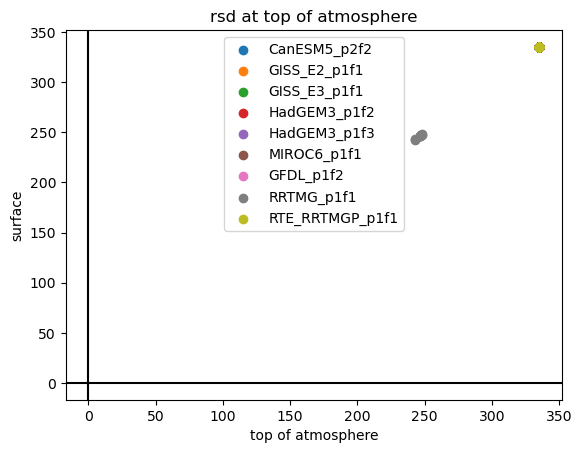

In [12]:
#show that the RRTMG input is different than the other RFMIP models
fig, ax = plt.subplots()
for m in list(gbms.keys()):
    plt.scatter(gbms[m].data_vars["rsd"][:,0],gbms[m].data_vars["rsd"][:,0])
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbms.keys()))
plt.title("rsd at top of atmosphere")
plt.show()

In [13]:
#calculate the forcing for parameterized and benchmark models by removing the present-day (experiment 0) baseline
#parameterized models
gbmforcing = gbms.copy()
for m in list(gbms.keys()):
    gbmforcing[m] = gbmforcing[m] - gbmforcing[m].isel(expt=0)
#benchmark models
gbmforcing_b = gbms_b.copy()
for m in list(gbms_b.keys()):
    gbmforcing_b[m] = gbmforcing_b[m] - gbmforcing_b[m].isel(expt=0)

In [14]:
#calculate the parameterization error using LBLRTM p1f1 as benchmark
gbmerror = {k: (gbmforcing[k]-gbmforcing_b['LBLRTM_p1f1']) for k in gbmforcing.keys()}

## probe pre-avgd TOA rsd values by model and experiment

In [86]:
#make a dataset of the pre-averaged parameterized model values
pre_avgd = {}
for m in list(cat.parameterized):
    for r in list(cat.parameterized[m]):
        components = list(cat.parameterized[m][r])
        pre_avgd[f'{m}_{r}'] = xr.concat([(cat.parameterized[m][r][f].to_dask()) 
                                        for f in components], 
                                        dim="field", data_vars = "different")
        if "rsd" in components:
            pre_avgd[f'{m}_{r}'] = pre_avgd[f'{m}_{r}'].assign(rsn=pre_avgd[f'{m}_{r}'].data_vars['rsd']-pre_avgd[f'{m}_{r}'].data_vars['rsu'])

pre_avgd = {k: pre_avgd[k].assign(rln=pre_avgd[k].data_vars['rld']-pre_avgd[k].data_vars['rlu']) for k in pre_avgd.keys()}
pre_avgd = {k: pre_avgd[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in pre_avgd.keys()}



In [84]:
#make a dataset of the pre-averaged parameterized model values
pre_avgd_b = {}
for m in list(cat.benchmark):
    for r in list(cat.benchmark[m]):
        components = list(cat.benchmark[m][r])
        pre_avgd_b[f'{m}_{r}'] = xr.concat([(cat.benchmark[m][r][f].to_dask()) 
                                        for f in components], 
                                        dim="field", data_vars = "different")
        if "rsd" in components:
            pre_avgd[f'{m}_{r}'] = pre_avgd_b[f'{m}_{r}'].assign(rsn=pre_avgd_b[f'{m}_{r}'].data_vars['rsd']-pre_avgd_b[f'{m}_{r}'].data_vars['rsu'])

pre_avgd_b = {k: pre_avgd_b[k].assign(rln=pre_avgd_b[k].data_vars['rld']-pre_avgd_b[k].data_vars['rlu']) for k in pre_avgd_b.keys()}
pre_avgd_b = {k: pre_avgd_b[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in pre_avgd_b.keys()}


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

In [99]:
pre_avgd_b["HadGEM3_p2f2"].rsd-pre_avgd_b["LBLRTM_p1f1"].rsd

<xarray.DataArray 'rsd' (expt: 18, site: 100, level: 61)>
array([[[-628.10986 , -627.917   , -627.6172  , ..., -468.81036 ,
         -468.07596 , -467.58246 ],
        [-548.9242  , -548.7234  , -548.4127  , ..., -398.83655 ,
         -398.16293 , -397.71173 ],
        [   0.      ,    0.      ,    0.      , ...,    0.      ,
            0.      ,    0.      ],
        ...,
        [-165.94232 , -165.76843 , -165.5085  , ..., -109.64447 ,
         -109.44294 , -109.30669 ],
        [-410.64215 , -410.46393 , -410.1844  , ..., -288.9416  ,
         -288.48914 , -288.18195 ],
        [-639.76276 , -639.57336 , -639.2755  , ..., -481.55426 ,
         -480.87283 , -480.4095  ]],

       [[-627.9592  , -627.7648  , -627.4567  , ..., -469.70114 ,
         -468.96686 , -468.4735  ],
        [-547.4471  , -547.24133 , -546.9215  , ..., -400.3816  ,
         -399.71204 , -399.26352 ],
        [   0.      ,    0.      ,    0.      , ...,    0.      ,
            0.      ,    0.      ],
...
        [-167.02654 , -166.83919 , -166.54121 , ..., -103.56619 ,
         -103.35353 , -103.209785],
        [-411.10678 , -410.91068 , -410.59973 , ..., -282.6276  ,
         -282.17404 , -281.8661  ],
        [-640.34607 , -640.1325  , -639.7991  , ..., -474.74414 ,
         -474.08725 , -473.64047 ]],

       [[-627.80615 , -627.6191  , -627.3152  , ..., -470.35693 ,
         -469.62177 , -469.12778 ],
        [-546.9159  , -546.71814 , -546.4025  , ..., -401.05667 ,
         -400.38785 , -399.93973 ],
        [   0.      ,    0.      ,    0.      , ...,    0.      ,
            0.      ,    0.      ],
        ...,
        [-165.90413 , -165.71837 , -165.45021 , ..., -110.73084 ,
         -110.52853 , -110.39171 ],
        [-410.586   , -410.4117  , -410.12976 , ..., -290.26096 ,
         -289.80582 , -289.49673 ],
        [-639.6502  , -639.46643 , -639.1657  , ..., -483.42984 ,
         -482.74557 , -482.28027 ]]], dtype=float32)
Coordinates:
    lat      (site) float32 -28.5 28.5 31.5 87.0 36.0 ... 64.5 58.5 -3.0 -24.0
    lon      (site) float32 27.0 24.0 162.0 126.0 66.0 ... 3.0 184.5 250.5 246.0
    time     (site) datetime64[ns] 2014-01-05T06:00:00 ... 2014-12-30
  * expt     (expt) object 'Present day (PD)' ... 'LGM'
Dimensions without coordinates: site, level

In [90]:
pre_avgd[]

<xarray.DataArray 'expt' (expt: 18)>
array(['Present day (PD)', 'Pre-industrial (PI) greenhouse gas concentrations',
       '4xCO2', '"future"', '0.5xCO2', '2xCO2', '3xCO2', '8xCO2', 'PI CO2',
       'PI CH4', 'PI N2O', 'PI O3', 'PI HCs', '+4K', '+4K, const. RH',
       'PI all', '"future" all', 'LGM'], dtype=object)
Coordinates:
  * expt     (expt) object 'Present day (PD)' ... 'LGM'

In [94]:
#find the difference between perturbed and present-day experiments for rsd values at TOA
rsd_differences = pre_avgd.copy()
for k in list(rsd_differences.keys()):
    rsd_differences[k] = rsd_differences[k]-rsd_differences[k].sel(expt="Present day (PD)")
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2117424
0.0


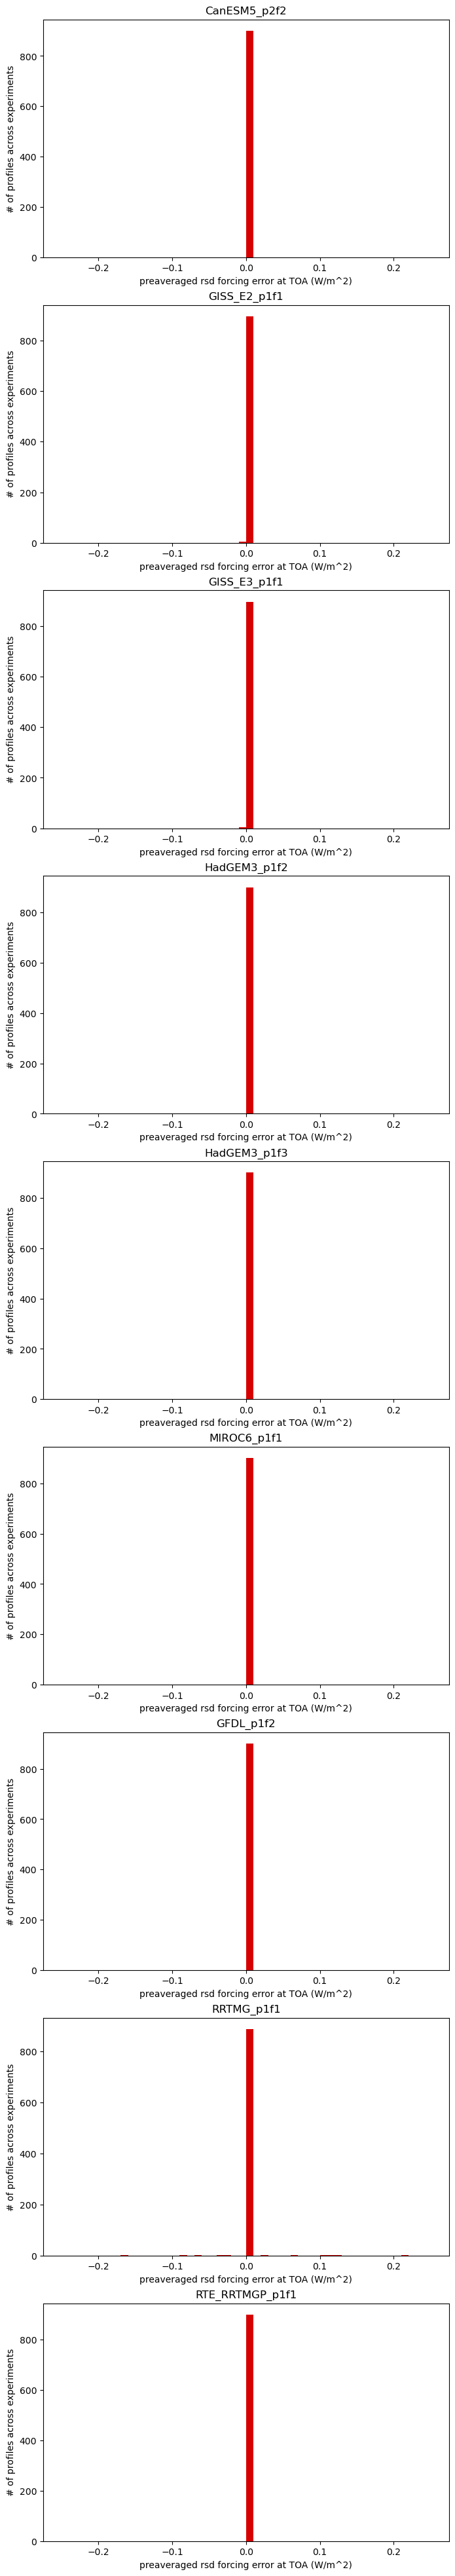

In [95]:
TOA = 0
#graph the error in rsd values at TOA in parameterized models across all experiments 
fig, (ax) = plt.subplots(9, figsize=(8,50))
i=0
for m in list(rsd_differences.keys()):
    ax[i].hist(rsd_differences[m].sel(level=TOA).rsd.values.flatten()-pre_avgd_b['LBLRTM_p1f1'].sel(level=TOA).rsd.values.flatten(), range=(-.25,.25), bins=50)
    print((rsd_differences[m].sel(level=TOA).rsd.values.flatten()-pre_avgd_b['LBLRTM_p1f1'].sel(level=TOA).rsd.values.flatten()).max())
    ax[i].set_title(m)
    ax[i].set_xlabel("preaveraged rsd forcing error at TOA (W/m^2)")
    ax[i].set_ylabel("# of profiles across experiments")
    i+=1

RRTMG p1f1 appears to be the only model with pre-averaged values significantly different than LBLRTM p1f1 (I limited the histogram range from -0.25 to 0.25 to reveal potential less obvious intermodel differences for the other models, but the rsd value differences between RRTMG and LBLRTM exceed |0.25| at many points)

In [96]:
#print the difference between parameterized and LBLRTM p1f1 AVERAGED TOA rsd values
for m in gbms.keys():
    print(m, gbms[m].rsd.sel(level=TOA)-gbms_b['LBLRTM_p1f1'].rsd.sel(level=TOA))

CanESM5_p2f2 <xarray.DataArray 'rsd' (expt: 18)>
array([0.5427551, 0.5427551, 0.5427551, 0.5427551, 0.5427551, 0.5427551,
       0.5427551, 0.5427551, 0.5427551, 0.5427551, 0.5427551, 0.5427551,
       0.5427551, 0.5427551, 0.5427551, 0.5427551, 0.5427551, 0.5427551],
      dtype=float32)
Coordinates:
  * expt     (expt) object 'Present day (PD)' ... 'LGM'
GISS_E2_p1f1 <xarray.DataArray 'rsd' (expt: 18)>
array([0.54263306, 0.54263306, 0.54263306, 0.54263306, 0.54263306,
       0.54263306, 0.54263306, 0.54263306, 0.54263306, 0.54263306,
       0.54263306, 0.54263306, 0.54263306, 0.54263306, 0.54263306,
       0.54263306, 0.54263306, 0.54263306], dtype=float32)
Coordinates:
  * expt     (expt) object 'Present day (PD)' ... 'LGM'
GISS_E3_p1f1 <xarray.DataArray 'rsd' (expt: 18)>
array([0.54263306, 0.54263306, 0.54263306, 0.54263306, 0.54263306,
       0.54263306, 0.54263306, 0.54263306, 0.54263306, 0.54263306,
       0.54263306, 0.54263306, 0.54263306, 0.54263306, 0.54263306,
       0.5426

With the exception of RRTMG p1f1, it seems that all the models have the same difference in _averaged_ rsd TOA values, despite showing no significant difference in pre-averaged rsd TOA values

## visualize data

In [34]:
CO2_experiments = ['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '4xCO2', '8xCO2']
model_colors = cc.glasbey_bw
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=model_colors) 

marker_shapes = ['+','>','^','o','D','s']

TOA=0
surface=60

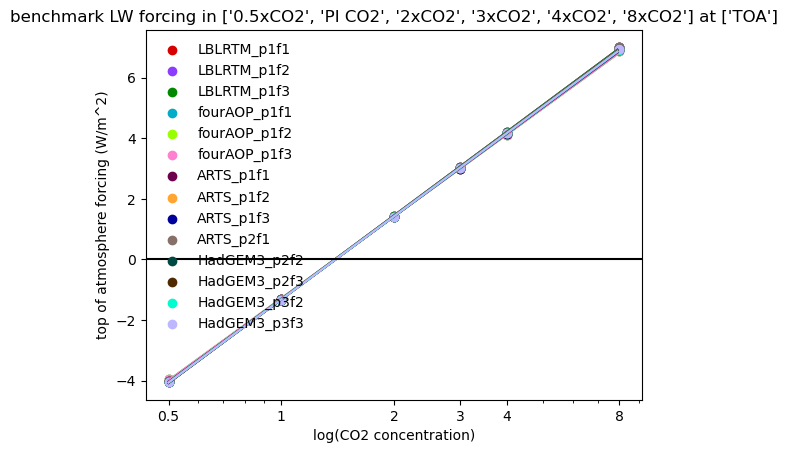

In [35]:
#benchmark longwave forcing in CO2 experiments at TOA

fig, ax = plt.subplots()
x=[0.5, 1, 2, 3, 4, 8]
y, y_values = concatenate_dataset(gbmforcing_b, gbmforcing_b.keys(), CO2_experiments, 'rln', TOA)

#plot data
for m in list(y.keys()):
    plt.scatter(x, y[m])
    
set_plot_parameters(x, y, 'gbmforcing_b', CO2_experiments, 'rln', ['TOA'], ['log(CO2 concentration)', 'top of atmosphere forcing (W/m^2)'], logscale=True, bestfit=True)

plt.show()


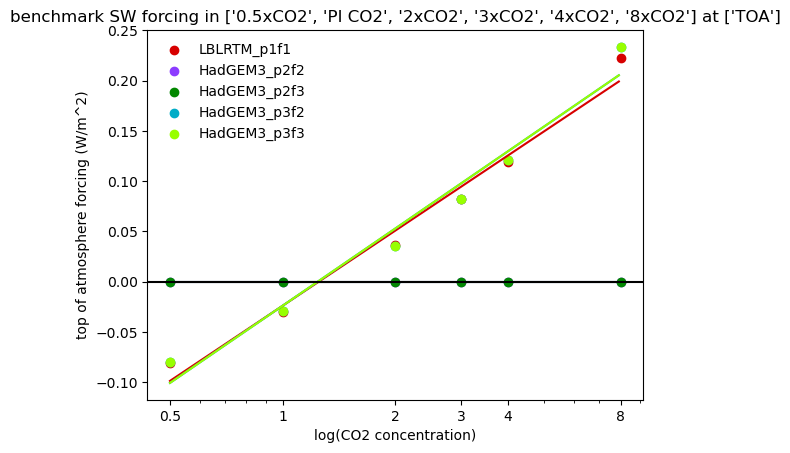

In [36]:
#benchmark longwave forcing in CO2 experiments at TOA

fig, ax = plt.subplots()
x=[0.5, 1, 2, 3, 4, 8]
y, y_values = concatenate_dataset(gbmforcing_b, gbmforcing_b.keys(), CO2_experiments, 'rsn', TOA)

#plot data
for m in list(y.keys()):
    plt.scatter(x, y[m])
    
set_plot_parameters(x, y, 'gbmforcing_b', CO2_experiments, 'rsn', ['TOA'], ['log(CO2 concentration)', 'top of atmosphere forcing (W/m^2)'], logscale=True, bestfit=True)

plt.show()


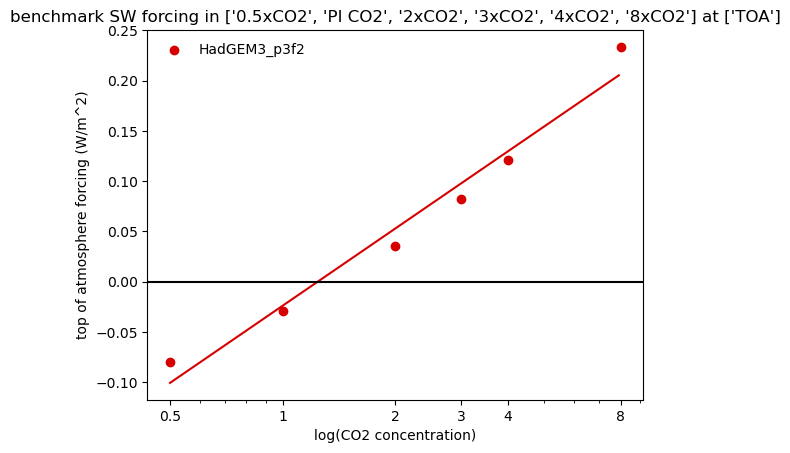

In [37]:
#benchmark longwave forcing in CO2 experiments at TOA

fig, ax = plt.subplots()
x=[0.5, 1, 2, 3, 4, 8]
y, y_values = concatenate_dataset(gbmforcing_b, ['HadGEM3_p3f2'], CO2_experiments, 'rsn', TOA)

#plot data
for m in list(y.keys()):
    plt.scatter(x, y[m])
    
set_plot_parameters(x, y, 'gbmforcing_b', CO2_experiments, 'rsn', ['TOA'], ['log(CO2 concentration)', 'top of atmosphere forcing (W/m^2)'], logscale=True, bestfit=True)

plt.show()


In [38]:
gbms_b['HadGEM3_p2f3'].sel(expt=['Present day (PD)'], level=0)

<xarray.Dataset>
Dimensions:         (expt: 1)
Coordinates:
  * expt            (expt) object 'Present day (PD)'
Data variables:
    rld             (expt) float32 -2.711e-10
    rsu             (expt) float32 47.69
    rsd             (expt) float32 47.69
    plev            float32 0.01
    rlu             (expt) float32 263.9
    profile_weight  float64 0.01053
    rsn             (expt) float32 0.0
    rln             (expt) float32 -263.9

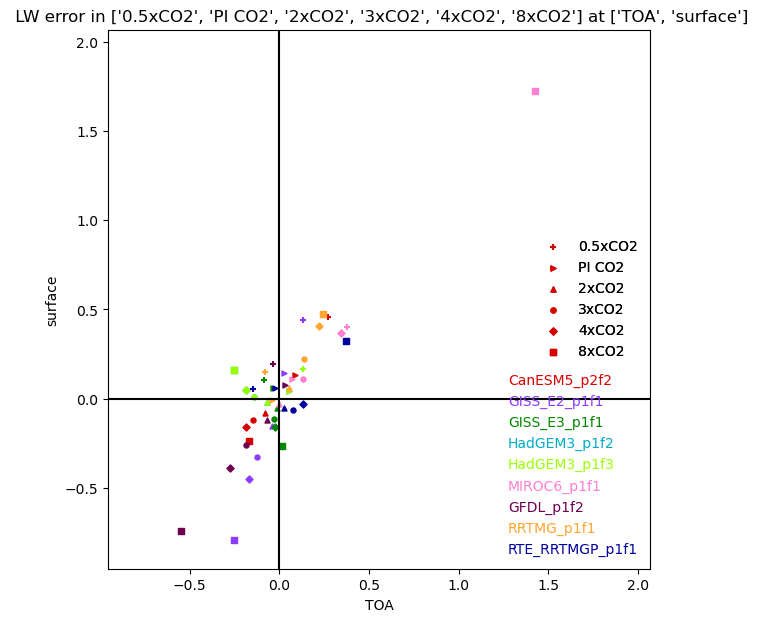

In [39]:
#parameterized longwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#select data (ds, models, selected_experiments, variable, level)
x, x_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rln', TOA)
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rln', surface)

color_cycler = 0
for m in list(gbmerror.keys()):
    for i in np.arange(len(CO2_experiments)):
        plt.scatter(x[m][i], y[m][i], color=model_colors[color_cycler], marker=marker_shapes[i],s=13)
    color_cycler+=1

set_plot_parameters(x, y, 'gbmerror', CO2_experiments, 'rln', ['TOA', 'surface'], ['TOA', 'surface'], legend=False, squareplot=True, x_values=x_values, y_values=y_values)

#create legends for experiment and model realization
legend1 = ax.legend(labels=gbmerror.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(labels=CO2_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend2)

plt.show()

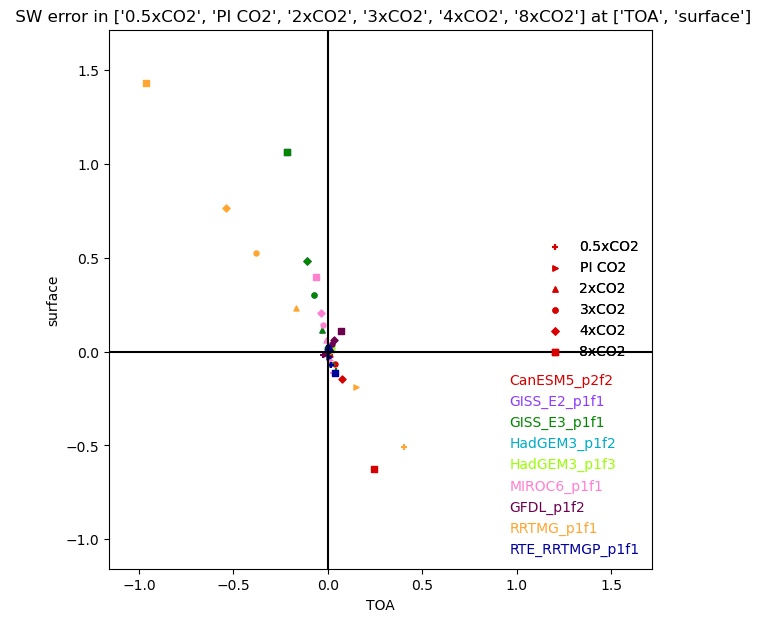

In [40]:
#parameterized shortwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#select data
x, x_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rsn', TOA)
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rsn', surface)

#plot data
color_cycler = 0
for m in gbmerror.keys():
    for i in np.arange(len(CO2_experiments)):
        plt.scatter(x[m][i], y[m][i], color = model_colors[color_cycler], marker=marker_shapes[i], s=13)
    color_cycler+=1

set_plot_parameters(x, y, 'gbmerror', CO2_experiments, 'rsn', ['TOA', 'surface'], ['TOA', 'surface'], legend=False, squareplot=True, x_values=x_values, y_values=y_values)

#create the legend
legend1 = ax.legend(labels=gbmerror.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(labels=CO2_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend2)

plt.show()

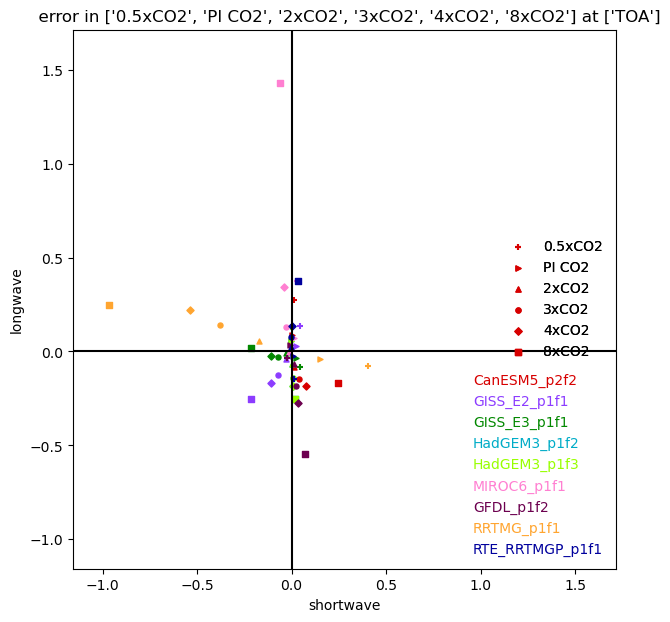

In [41]:
#parameterized longwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#select data
x, x_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rsn', TOA)
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rln', TOA)

#plot data
color_cycler = 0
for m in list(gbmerror.keys()):
    for i in np.arange(len(CO2_experiments)):
        plt.scatter(x[m][i], y[m][i], color = model_colors[color_cycler], marker = marker_shapes[i], s=13)
    color_cycler+=1

set_plot_parameters(x, y, 'gbmerror', CO2_experiments, ['rsn', 'rln'], ['TOA'], ['shortwave', 'longwave'], legend=False, squareplot=True, x_values=x_values, y_values=y_values)

#create the legend
legend1 = ax.legend(labels=gbmerror.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(labels=CO2_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend2)

plt.show()

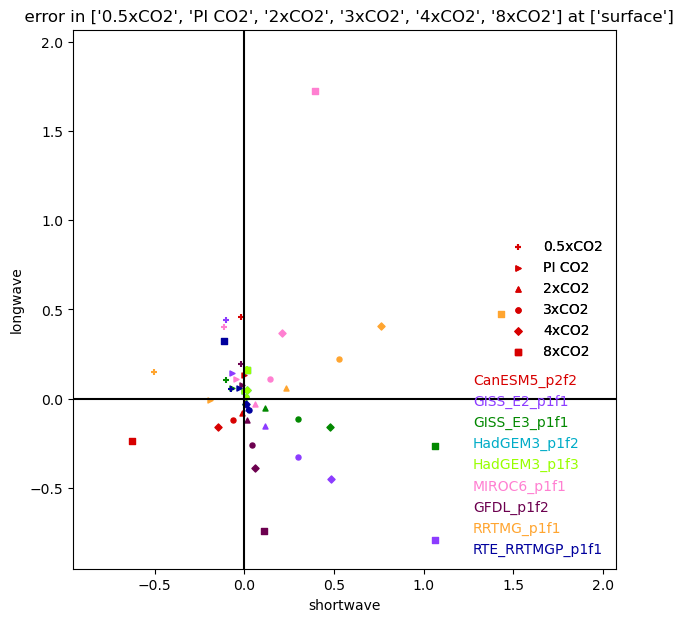

In [42]:
#parameterized longwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#select data
x, x_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rsn', surface)
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rln', surface)

#plot data
color_cycler = 0
for m in list(gbmerror.keys()):
    for i in np.arange(len(CO2_experiments)):
        plt.scatter(x[m][i], y[m][i], color = model_colors[color_cycler], marker = marker_shapes[i], s=13)
    color_cycler+=1

set_plot_parameters(x, y, 'gbmerror', CO2_experiments, ['rsn', 'rln'], ['surface'], ['shortwave', 'longwave'], legend=False, squareplot=True, x_values=x_values, y_values=y_values)

#create the legend
legend1 = ax.legend(labels=gbmerror.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(labels=CO2_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend2)

plt.show()

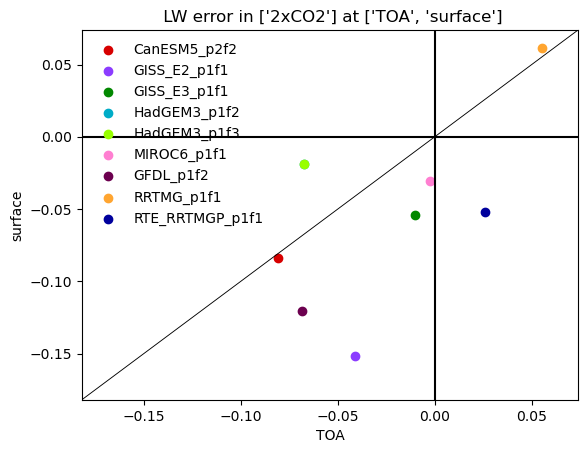

In [43]:
#parameterized longwave error in 2xCO2 experiment
fig, ax = plt.subplots()
selected_experiments = ['2xCO2']

x, x_values = concatenate_dataset(gbmerror, gbmerror.keys(), ['2xCO2'], 'rln', TOA)
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), ['2xCO2'], 'rln', surface)

#plot data
for m in list(x.keys()):
    plt.scatter(x[m], y[m])

set_plot_parameters(x, y, 'gbmerror', ['2xCO2'], 'rln', ['TOA', 'surface'], ['TOA', 'surface'], isoline=True, squareplot=True, x_values=x_values, y_values=y_values)

plt.show()

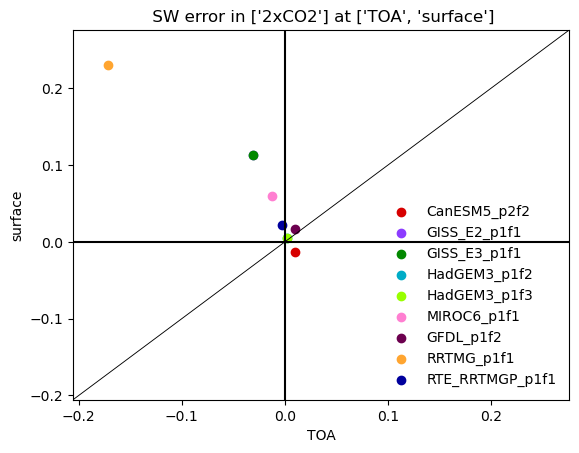

In [44]:
#parameterized longwave error in 2xCO2 experiment
fig, ax = plt.subplots()
selected_experiments = ['2xCO2']

x, x_values = concatenate_dataset(gbmerror, gbmerror.keys(), ['2xCO2'], 'rsn', TOA)
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), ['2xCO2'], 'rsn', surface)

#plot data
for m in list(x.keys()):
    plt.scatter(x[m], y[m])

set_plot_parameters(x, y, 'gbmerror', ['2xCO2'], 'rsn', ['TOA', 'surface'], ['TOA', 'surface'], isoline=True, squareplot=True, x_values=x_values, y_values=y_values)

plt.show()

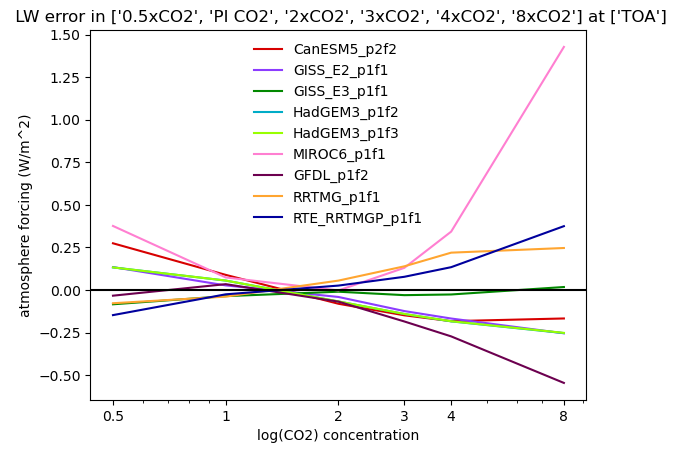

In [45]:
#parameterized longwave error in CO2 experiments at TOA
fig, ax = plt.subplots()
x=[0.5, 1, 2, 3, 4, 8]
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rln', TOA)

#plot data
for m in list(y.keys()):
    plt.plot(x, y[m])

#set plot parameters
set_plot_parameters(x, y, 'gbmerror', CO2_experiments, 'rln', ['TOA'], ['log(CO2) concentration', 'atmosphere forcing (W/m^2)'], logscale=True)

plt.show()

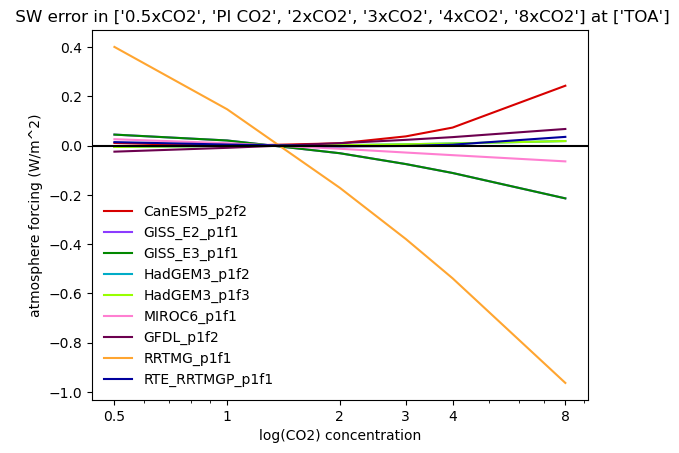

In [46]:
#parameterized longwave error in CO2 experiments at TOA
fig, ax = plt.subplots()
x = [0.5, 1, 2, 3, 4, 8]
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rsn', TOA)

#plot data
for m in list(y.keys()):
    plt.plot(x, y[m])

#set plot parameters
set_plot_parameters(x, y, 'gbmerror', CO2_experiments, 'rsn', ['TOA'], ['log(CO2) concentration', 'atmosphere forcing (W/m^2)'], logscale=True)

plt.show()

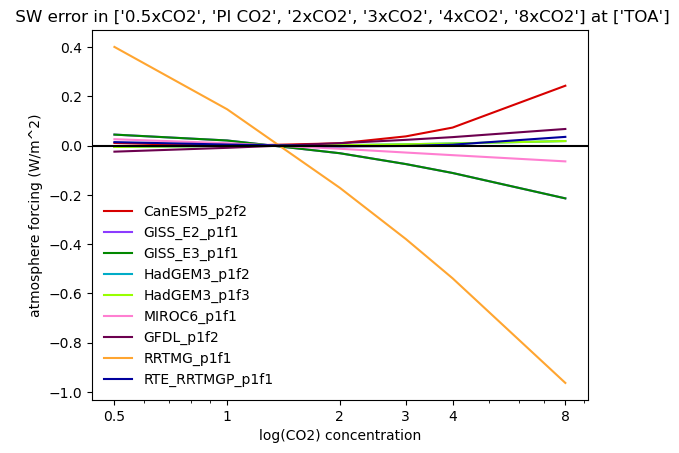

In [47]:
#parameterized longwave error in CO2 experiments at TOA
fig, ax = plt.subplots()
x = [0.5, 1, 2, 3, 4, 8]
y, y_values = concatenate_dataset(gbmerror, gbmerror.keys(), CO2_experiments, 'rsn', TOA)

#plot data
for m in list(y.keys()):
    plt.plot(x, y[m])

#set plot parameters
set_plot_parameters(x, y, 'gbmerror', CO2_experiments, 'rsn', ['TOA'], ['log(CO2) concentration', 'atmosphere forcing (W/m^2)'], logscale=True)

plt.show()

### extra graphs- logCO2 error deviation from logarithmic model

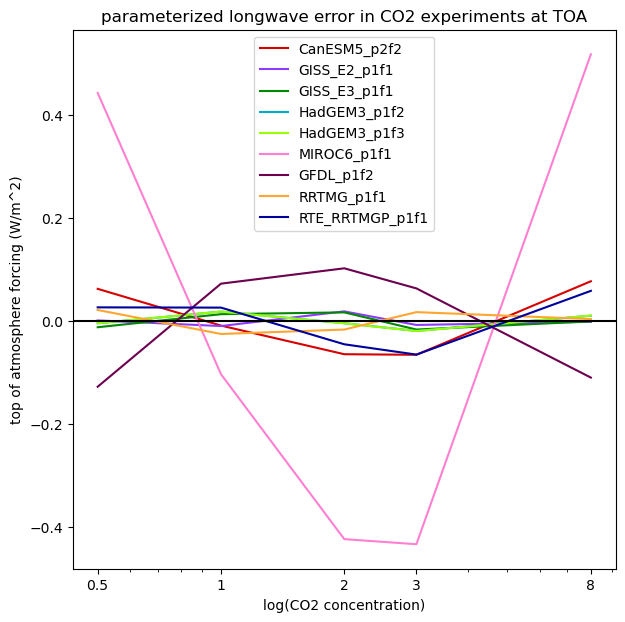

In [48]:
#plot longwave parameterization error deviation from logarithmic (by model realization)
fig, ax = plt.subplots(figsize=(7,7))

deviation = {}

#find a logarithmic model for each realization    
for m in list(gbmerror.keys()):
    t = np.log10([0.5, 1, 2, 3, 8])
    y = gbmerror[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
    p = np.polyfit(t, y, 1)    
    y_model = p[0] * np.log10([0.5,1,2,3,8]) + p[1]
    deviation.update({str(m): y-y_model})

#plot the deviation from the logarithmic model
for m in list(gbmerror.keys()):
    plt.plot([0.5, 1, 2, 3, 8], deviation[m])

#scale logarithmically and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(gbmerror.keys())
plt.title("parameterized longwave error in CO2 experiments at TOA")
plt.show()

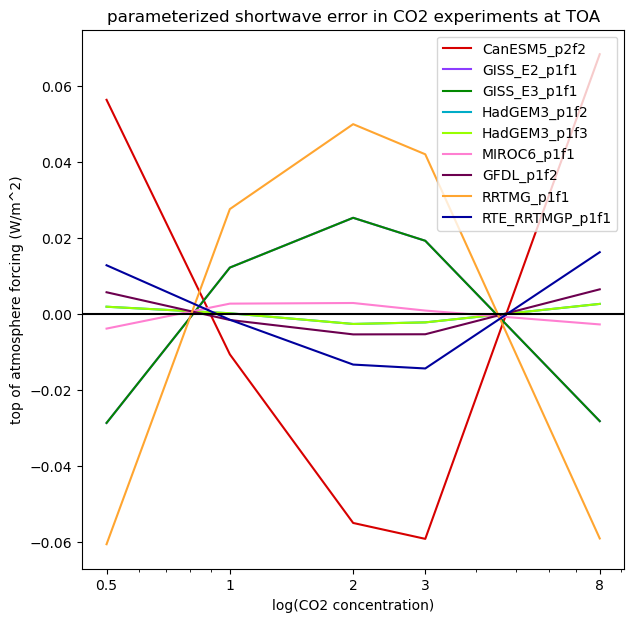

In [49]:
#plot shortwave parameterization error deviation from logarithmic (by model realization)
fig, ax = plt.subplots(figsize=(7,7))

deviation = {}

#find a logarithmic model for each realization    
for m in list(gbmerror.keys()):
    t = np.log10([0.5, 1, 2, 3, 8])
    y = gbmerror[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
    p = np.polyfit(t, y, 1)    
    y_model = p[0] * np.log10([0.5,1,2,3,8]) + p[1]
    deviation.update({str(m): y-y_model})

#plot the deviation from the logarithmic model
for m in list(gbmerror.keys()):
    plt.plot([0.5, 1, 2, 3, 8], deviation[m])

#scale logarithmically and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(gbmerror.keys())
plt.title("parameterized shortwave error in CO2 experiments at TOA")
plt.show()